In [1]:
library(ggplot2)
options(repr.plot.width=5, repr.plot.height=3)

set.seed(1)
n <- 10
lam <- 1.5

# Sampling distribution

We want to understand estimators from a frequentist perspective: "what happens if we repeat the experiment many times"

As an example, we consider a sample from the Poisson distribution with parameter $\lambda$.
Note the mean is $\lambda$ and the variance is also $\lambda$.

We won't go through the math, but it's a good exercise to show the MLE estimator for $\lambda$ is the sample mean $\bar{X}$.

In [2]:
x <- rpois(n, lam)
cat("Sample:", x, "\n")
cat("Mean", mean(x))

mle.x <- mean(x)

Sample: 1 1 2 3 0 3 4 2 2 0 
Mean 1.8

In [3]:
sampling <- function(n, lam) {
    x <- rpois(n, lam)
    mean(x)
}

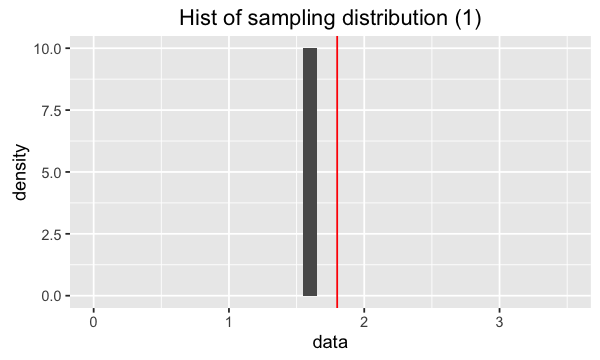

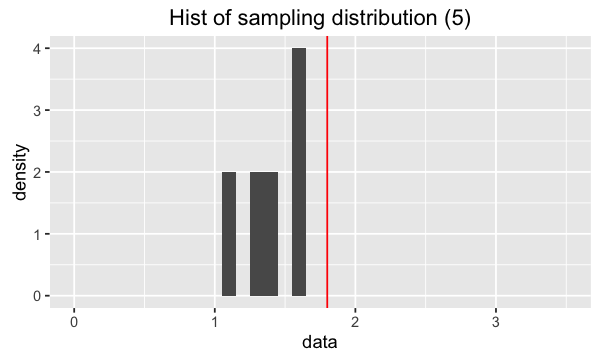

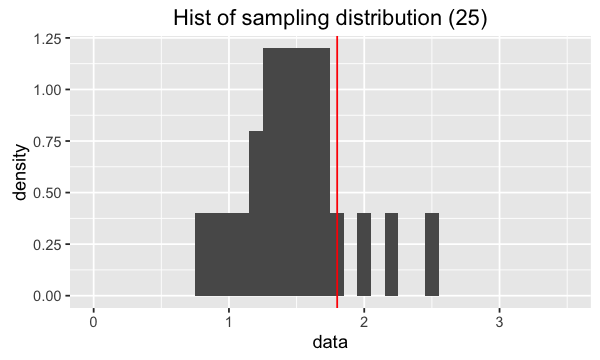

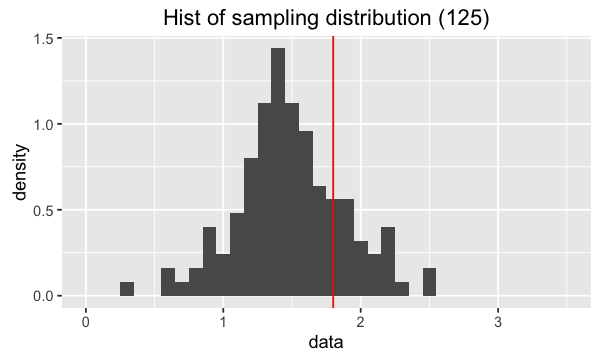

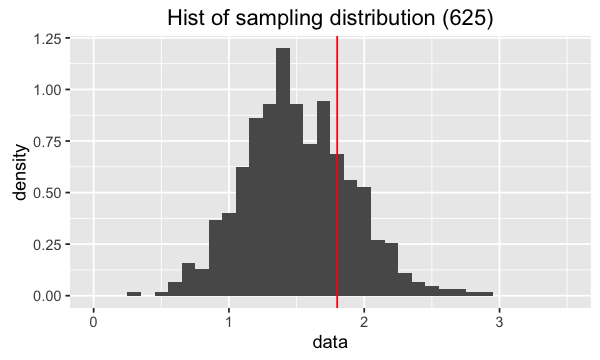

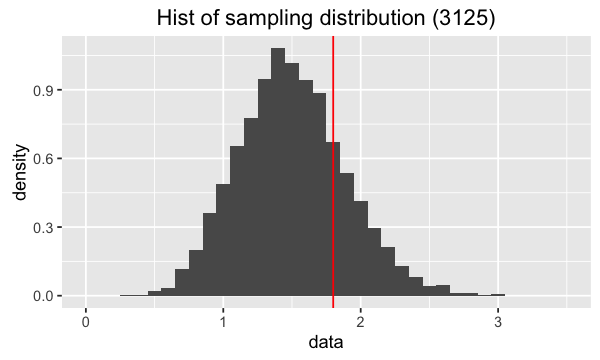

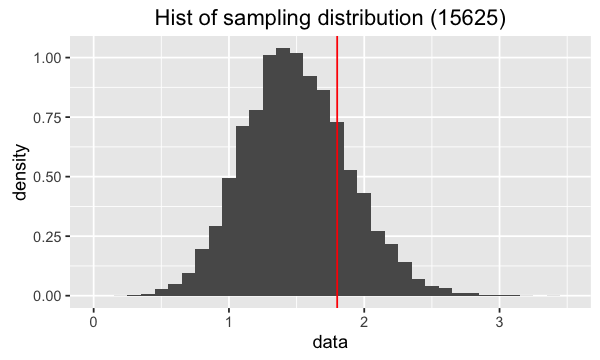

In [4]:
data <- c()
for (i in 1:7) {
    nrep <- max(1, 4*length(data))
    data <- c(data, replicate(nrep, sampling(n, lam)))

    p <- ggplot() + 
        geom_histogram(aes(x=data, y=..density..), binwidth=0.1) + 
        coord_cartesian(xlim = c(0, 3.5)) +
        labs(title=paste0("Hist of sampling distribution (", length(data), ")")) + 
        geom_vline(xintercept=mean(x), color="red")
    print(p)
}

# Standard error

Standard error is the standard deviation of the sampling distribution

In [5]:
sdev <- sd(x)
se <- sqrt(mean(data)/n)
se.hat <- sqrt(mle.x/n)

cat("Sample standard deviation: ", sd(x), "\n")
cat("Estimated standard error:  ", se.hat, "\n")
cat("'True' standard error:     ", se, "\n")
cat("True standard error:       ", sqrt(lam)/sqrt(n))

Sample standard deviation:  1.316561 
Estimated standard error:   0.4242641 
'True' standard error:      0.3870297 
True standard error:        0.3872983

# Constructing a confidence interval

What is a confidence interval: a **random** interval that contains the **fixed** truth with a determined probability.
Don't forget what is random and what is fixed.

(Ab)using the central limit theorem, we know that as we get more samples, the sampling distribution converges to a normal distribution.

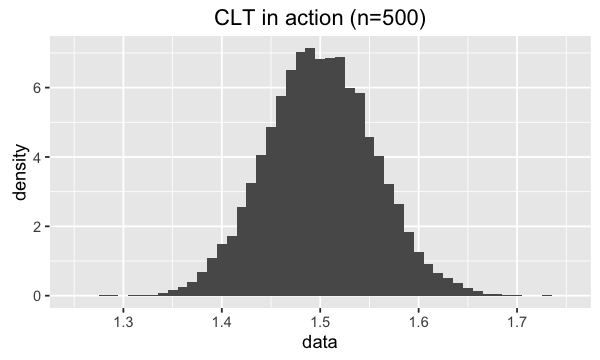

In [6]:
nrep.big <- 15625
n.big <- 500
data <- replicate(nrep.big, sampling(n.big, lam))

p <- ggplot() + 
    geom_histogram(aes(x=data, y=..density..), binwidth=0.01) + 
    coord_cartesian(xlim = c(1.25, 1.75)) +
    labs(title=paste0("CLT in action (n=", n.big, ")")) + 
    geom_vline(xintercept=mean(x), color="red", alpha=0.5)
print(p)

In [7]:
cat("MLE estimate:         ", mean(x), "\n")
cat("Confidence interval: (", round(mean(x)-1.96*se.hat, 2), ", ", round(mean(x)+1.96*se.hat, 2), ")")

MLE estimate:          1.8 
Confidence interval: ( 0.97 ,  2.63 )

## Asymptotics

We only have 10 samples; too little to trust the asymptotic CLT.
Can we use bootstrap?

Idea: use the **empirical distribution** as surrogate for the (unknown) distribution

Question: How many bootstap samples to draw? 

In [8]:
x.boot <- sample(x, length(x), replace=T)
cat("Bootstrapped sample:", x.boot, "\n")
cat("Bootstrapped sample mean:", mean(x.boot))

Bootstrapped sample: 2 3 1 3 0 4 2 2 0 0 
Bootstrapped sample mean: 1.7

Repeat the above many times

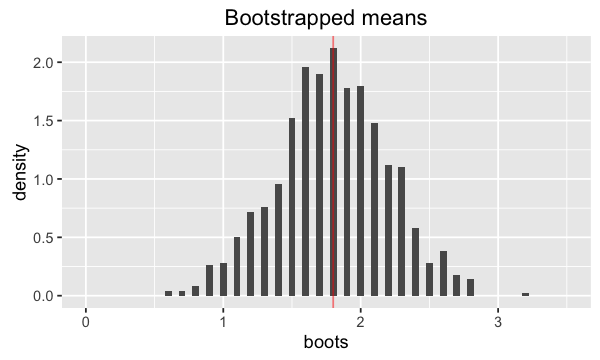

In [9]:
n.boot <- 1000
boots <- replicate(n.boot, 
                   (function() {mean(sample(x, length(x), replace=T))})())

p <- ggplot() + 
    geom_histogram(aes(x=boots, y=..density..), binwidth=0.05) + 
    coord_cartesian(xlim = c(0, 3.5)) +
    labs(title=paste0("Bootstrapped means")) + 
    geom_vline(xintercept=mean(x), color="red", alpha=0.5)
print(p)

We compute the bootstrapped confidence intervals using the quantile function.
It leads to an almost identical interval.

In [10]:
alpha <- 0.05
quantile(boots, probs=c(alpha/2, 1-alpha/2))

2.5% 97.5% 
  1.0   2.6

Note here that the bootstrap is also not perfect, as we only have 10 samples; that's too few. The empirical distribution does not approximate the true underlying distribution well.

Hence, while it helps to get as many samples as we can from the underlying distribution (more always better), this is less so the case for the bootstrap. While we reduce variance in our samples from the bootstrap, there is an irreducible error from the approximation of the underlying distribution with the empirical distribution.

We cannot reduce our error: there is no point in being **precisely wrong**.

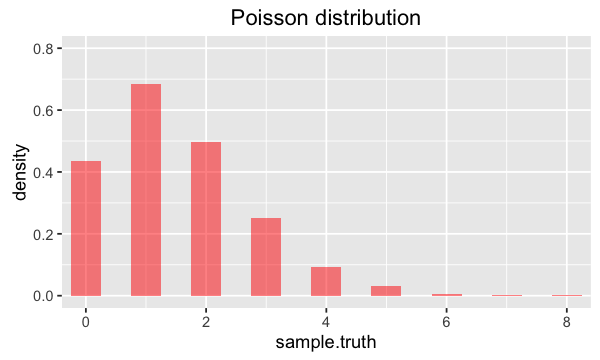

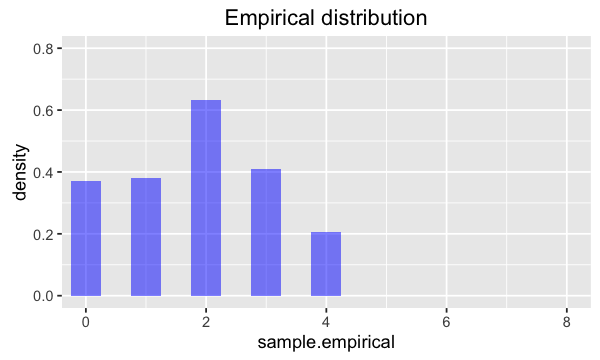

In [11]:
n.hist <- 2000

sample.truth <- rpois(n.hist, lam)
sample.empirical <- sample(x, n.hist, replace=T)

p <- ggplot() +
    geom_histogram(aes(x=sample.truth, y=..density..), binwidth=0.5, fill="red", alpha=0.5) + 
    coord_cartesian(xlim = c(0, 8), ylim=c(0, 0.8)) +
    labs(title="Poisson distribution")
print(p)

p <- ggplot() +
    geom_histogram(aes(x=sample.empirical, y=..density..), binwidth=0.5, fill="blue", alpha=0.5) +
    coord_cartesian(xlim = c(0, 8), ylim=c(0, 0.8)) +
    labs(title="Empirical distribution")
print(p)

# Big Game Bonus: sampling for hypothesis testing

Power of bootstap: it is really simple, no math needed. 
We can adapt this to hypothesis testing as well.

Suppose we want to test whether Stanford students are smarter than Berkeley students.
We have a test that measures how smart individuals are and have 10 Stanford undergrads and 10 Berkeley undergrads take the test. The outcomes are as follows:

In [12]:
stanford <- c(10, 23, 14, 8, 25, 15, 9, 16, 9, 12)
berkeley <- c(9, 11, 6, 13, 19, 17, 4, 12, 4, 20)
diff <- mean(stanford) - mean(berkeley)

cat("Mean Stanford students: ", mean(stanford), "\n")
cat("Mean Berkeley students: ", mean(berkeley), "\n")
cat("Difference:              ", diff)

Mean Stanford students:  14.1 
Mean Berkeley students:  11.5 
Difference:               2.6

Can we conclude Stanford students are smarter? Or is this because of noise?

Idea: if there is no difference, then we should be able to randomly assign students to two groups and get similar differences. Why don't we repeat this a bunch of times and see what expected difference we observe?

In [20]:
all.students <- c(stanford, berkeley)
random.diff <- function() {
    n <- length(all.students)
    indices <- sample.int(n, n/2)
    mean(all.students[indices]) - mean(all.students[-indices])
}

random.diff()

[1] -3.8

In [14]:
n.permutations <- 1000
output <- replicate(n.permutations, random.diff())

quantile(output, probs=c(alpha/2, 1-alpha/2))

2.5%  97.5% 
-5.005  4.800

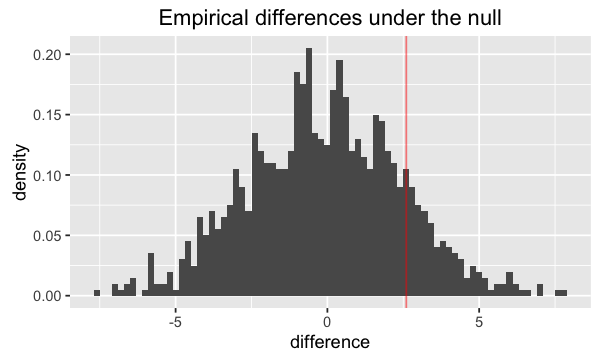

In [15]:
ggplot() +
    geom_histogram(aes(x=output, y=..density..), binwidth=0.2) +
    geom_vline(xintercept=diff, color="red", alpha=0.5) + 
    labs(title="Empirical differences under the null", x="difference")

Suppose we gather 5 times as much data (but because I am lazy, I just copy the score outcomes 5 times).
Note that the mean difference will still be the same

In [16]:
all.students <- c(rep(stanford, 5), rep(berkeley, 5))
random.diff <- function() {
    n <- length(all.students)
    indices <- sample.int(n, n/2)
    mean(all.students[indices]) - mean(all.students[-indices])
}

random.diff()

[1] 1.56

In [17]:
n.permutations <- 1000
output <- replicate(n.permutations, random.diff())

quantile(output, probs=c(alpha/2, 1-alpha/2))

2.5% 97.5% 
-2.28  2.20

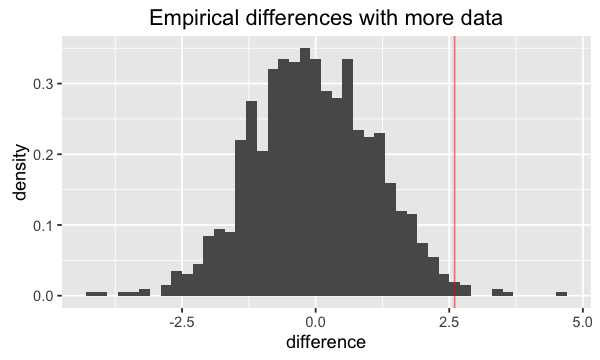

In [18]:
ggplot() +
    geom_histogram(aes(x=output, y=..density..), binwidth=0.2) +
    geom_vline(xintercept=diff, color="red", alpha=0.5) + 
    labs(title="Empirical differences with more data", x="difference")

In this case, we can reject the null hypothesis that there is no difference between the two groups.